Generating Adversarial Images Using the Carlini & Wagner Attack

/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 20:29:57.779182: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 92.77 url/s] 
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 60.23 url/s]
2025-04-21 20:30:09.798798: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Dataset imagenet_v2 downloaded and prepared to /Users/sharansgowda/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.
Epoch 0: Loss = 0.0


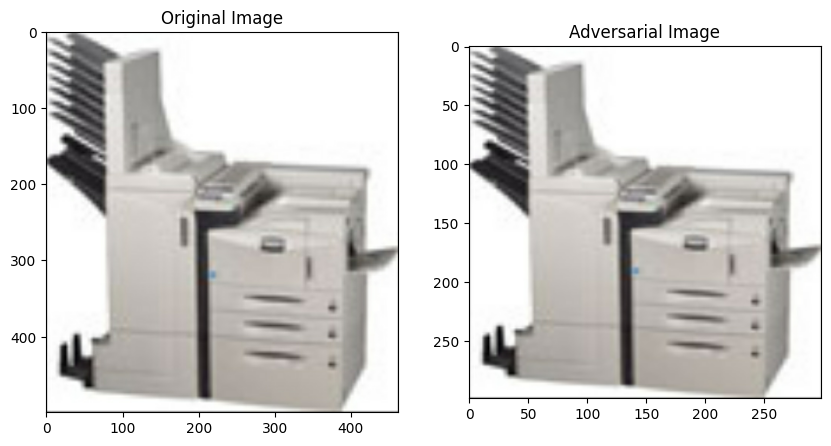

Dl Completed...: 100%|██████████| 5/5 [00:05<00:00,  1.18s/ file]
2025-04-21 20:30:44.670160: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset mnist downloaded and prepared to /Users/sharansgowda/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Epoch 0: Loss = 0.0


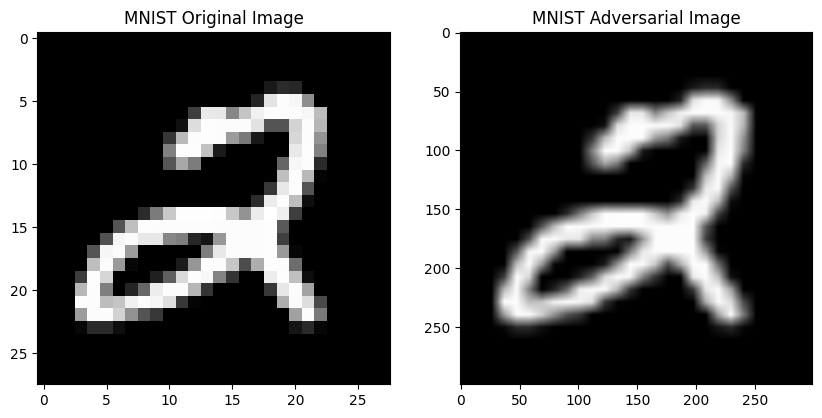

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
model = hub.KerasLayer(model_url, trainable=False)

# Load and preprocess the image from ImageNet dataset
imagenet_dataset, info = tfds.load('imagenet_v2', split='test', with_info=True)
imagenet_batch = next(iter(imagenet_dataset.batch(1)))

image, label = imagenet_batch['image'][0], imagenet_batch['label'][0]

image_resized = tf.image.resize(image, (299, 299)) / 255.0
image_resized = tf.expand_dims(image_resized, 0)

# Define the Carlini & Wagner (C&W) attack class
class CW:
    def __init__(self, model, targeted=True, c=1e-4, kappa=0, lr=1e-2, epochs=1000, batch_size=1):
        self.model = model
        self.targeted = targeted
        self.c = c
        self.kappa = kappa
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

    def _loss(self, x, y, x_adv):
        # Calculate the loss function for the attack
        f = self._f(x_adv, y)
        return tf.reduce_sum(tf.square(x - x_adv)) + self.c * tf.reduce_sum(f)

    def _f(self, x_adv, y):
        logits = self.model(x_adv)
        y_true = tf.one_hot(y, 1001)
        y_true = tf.squeeze(y_true)
        real = tf.reduce_sum(y_true * logits, axis=1)
        other = tf.reduce_max((1 - y_true) * logits - y_true * 10000, axis=1)
        if self.targeted:
            return tf.maximum(other - real, -self.kappa)
        else:
            return tf.maximum(real - other, -self.kappa)

    def generate(self, x, y):
        # Generate the adversarial image
        x_adv = tf.identity(x)  # Create a copy of the input image
        x_adv = tf.Variable(x_adv)

        optimizer = tf.keras.optimizers.Adam(self.lr)

        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                loss = self._loss(x, y, x_adv)
            gradients = tape.gradient(loss, [x_adv])
            optimizer.apply_gradients(zip(gradients, [x_adv]))

            x_adv.assign(tf.clip_by_value(x_adv, 0, 1))

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.numpy()}")

        return x_adv

# Instantiate the C&W attack class and generate the adversarial image
cw = CW(model=model, targeted=False, epochs=100, batch_size=1)

# Generate the adversarial image
adv_image = cw.generate(image_resized, label)

# Display the original and adversarial images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(tf.squeeze(image))

plt.subplot(1, 2, 2)
plt.title("Adversarial Image")
plt.imshow(tf.squeeze(adv_image))

plt.show()

# Load and preprocess the MNIST dataset
mnist_dataset, mnist_info = tfds.load('mnist', split='test', with_info=True)
mnist_batch = next(iter(mnist_dataset.batch(1)))

mnist_image, mnist_label = mnist_batch['image'][0], mnist_batch['label'][0]

# Convert MNIST image to RGB and resize
mnist_image_resized = tf.image.resize(tf.image.grayscale_to_rgb(mnist_image), (299, 299)) / 255.0
mnist_image_resized = tf.expand_dims(mnist_image_resized, 0)

# Generate the adversarial image for the MNIST input
mnist_adv_image = cw.generate(mnist_image_resized, mnist_label)

# Display the new images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("MNIST Original Image")
plt.imshow(tf.squeeze(mnist_image), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("MNIST Adversarial Image")
plt.imshow(tf.squeeze(mnist_adv_image))

plt.show()


Conclusion

In this notebook, we implemented the Carlini & Wagner (C&W) attack to generate adversarial images for a pre-trained image classification model. The C&W attack is a powerful technique that minimizes the perturbation added to the original image while causing the model to misclassify it. By comparing the original and adversarial images, we can see that the perturbations are often imperceptible to the human eye but can significantly affect the model's predictions. This demonstrates the vulnerability of machine learning models to adversarial attacks and highlights the need for developing robust defense mechanisms.

